# Replication results of EGARPS on three testing sets
**Ready to run:**<br>
Users need to download the [model weights](https://drive.google.com/file/d/1Fux72Ayp1g_k7yxytfA0ki_WSoxX51Aa/view?usp=drive_link) and unzip it into the *weights* folder.<br>
Metadata can be downloaded from [https://liulab.hzau.edu.cn/EGARPS/data.html]<br>
Environment configuration reference *enviroment.txt*. pytorch and dgl are indispensable!<br>
**Note:**<br>
The following results were tested on 8 cpu cores, 20.0G RAM, and 1 RTX 3080 GPU with 10G of VRAM.<br>

In [1]:
pip show torch

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /work/home/lr_hzau/anaconda3/envs/jz_dl/lib/python3.10/site-packages
Requires: typing-extensions
Required-by: lion-pytorch, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show dgl

Name: dgl
Version: 1.0.1+cu113
Summary: Deep Graph Library
Home-page: https://github.com/dmlc/dgl
Author: 
Author-email: 
License: APACHE
Location: /work/home/lr_hzau/anaconda3/envs/jz_dl/lib/python3.10/site-packages
Requires: networkx, numpy, psutil, requests, scipy, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
import numpy as np
import dgl
import torch

/work/home/lr_hzau/anaconda3/envs/jz_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
sys.path.append('../scripts')
from Models_res import Graph_Model

In [5]:
import matplotlib.pyplot as plt

In [6]:
#model load function
def load_model(version, device='cuda'):
    model = Graph_Model(mid=version)
    model.load_state_dict(torch.load(
            '../weights/{}.pth'.format(version),
        map_location='cpu'))
    model.to(device)
    model.eval()
    return model

In [7]:
#data loader
def load_data(p):
    with open(p, 'rb') as f:
        bgs, _, tags = pickle.load(f)
    return bgs, tags

In [8]:
#rmsd load
def load_rmsd(r):
    with open(r, 'rb') as f:
        rmsd = pickle.load(f)
    return rmsd

In [9]:
#install rmsd
def install_rmsd(r, rmsd):
    s = dict()
    for k,v in r.items():
        s[k] = [[x,y,rmsd[k][x]] for x,y in zip(*v)]
    return s

In [10]:
#success rate
class Success(object):
    def __init__(self, topn=None):
        if topn is None:
            self.topn = list(range(1, 10, 1)) + list(range(10, 100, 10)) + list(range(100, 1001, 100))
        else:
            self.topn = topn
    
    def _success(self, on):
        rate = list()
        for t in self.topn:
            tr = [float(x[-1]) for x in on[:t]]
            if any([r<=4 for r in tr]):
                rate.append(1)
            else:
                rate.append(0)
        return rate

    def _rate(self, a, reverse):
        rate = list()
        for k,v in a.items():
            v.sort(key=lambda x:x[1], reverse=reverse)
            rate.append(self._success(v))
        rate = np.array(rate).mean(axis=0)
        return rate

    def __call__(self, a, reverse=True):
        return self._rate(a, reverse)

In [11]:
#prediction function
class Predict(object):
    def __init__(self, vs, ps):
        self.vs = vs
        self.ps = ps
    
    def __call__(self):
        ds = [self._base(v) for v in self.vs]
        sc = self._mer(ds, ds[0].keys())
        return sc
    
    def _predict(self, bgs, model):
        predictions = list()
        with torch.no_grad():
            for bg in bgs:
                bg = [x.to(next(model.parameters()).device) for x in bg]
                _, prediction = model(bg)
                predictions.append(prediction.to('cpu').numpy())
        return np.row_stack(predictions)

    def _base(self, v):
        model = load_model(v)
        record = dict()
        for p in self.ps:
            bgs, tags = load_data(p)
            predictions = self._predict(bgs, model)
            record[tags[0]] = {x:y for x,y in zip(tags[1:], predictions)}
        return record

    def _mer(self, ds, ks):
        o = dict()
        for k in ks:
            cs = list(ds[0][k].keys())
            ss = [np.mean([d[k][c] for d in ds]) for c in cs]
            o[k] = (cs, ss)
        return o

In [12]:
#plot function
class Plot(object):
    def __init__(self, dataset):
        if dataset == 'test1':
            self.ylim = 102
        elif dataset == 'test2':
            self.ylim = 75
        elif dataset == 'test3':
            self.ylim = 57
        else:
            raise ValueError()
        self.colors = ['#C82423','#B66262']
        self.ticks = list(range(1, 10, 1)) + list(range(10, 100, 10)) + list(range(100, 1001, 100))
    
    def _ax(self, ax):
        ax.tick_params(labelsize=12)
        labels=ax.get_xticklabels()+ax.get_yticklabels()
        #[label.set_fontname('Arial') for label in labels]
        ax.spines['top'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['right'].set_linewidth(1.5)

    def _plot(self, data, color):
        plt.plot(data*100, marker='v', markersize=12, clip_on=False, zorder=5, linewidth=2., 
                color=color)
    
    def _xticks(self):
        plt.xticks(range(0, len(self.ticks), 2), 
                  ['{}'.format(self.ticks[i]) for i in range(0, len(self.ticks), 2)])
    
    def _yticks(self):
        plt.yticks(range(0, self.ylim, 10),
                  ['{}'.format(i) for i in range(0, self.ylim, 10)])
    
    def plot(self, ds):
        plt.figure()
        for i,d in enumerate(ds):
            self._plot(d, self.colors[i])
        self._xticks()
        self._yticks()
        self._ax(plt.gca())
        plt.show()

In [13]:
#top1 to top1000 success rate
def performance(dataset):
    rmsd = load_rmsd('../metadata/RMSD.pkl')
    
    fs = ['../metadata/{}/{}'.format(dataset, x) for x in sorted(os.listdir('../metadata/'+dataset))]
    predictor_o = Predict([x.split('.')[0] for x in os.listdir('../weights/') if x[0]=='m'], fs)
    od = predictor_o()
    predictor_p = Predict([x.split('.')[0] for x in os.listdir('../weights/') if x[0]=='p'], fs)
    pd = predictor_p()

    odr = install_rmsd(od, rmsd[dataset[:-1]+'ing_set'+dataset[-1]])
    pdr = install_rmsd(pd, rmsd[dataset[:-1]+'ing_set'+dataset[-1]])

    su = Success()
    ro = su(odr)
    rp = su(pdr)

    p = Plot(dataset)
    p.plot((ro, rp))

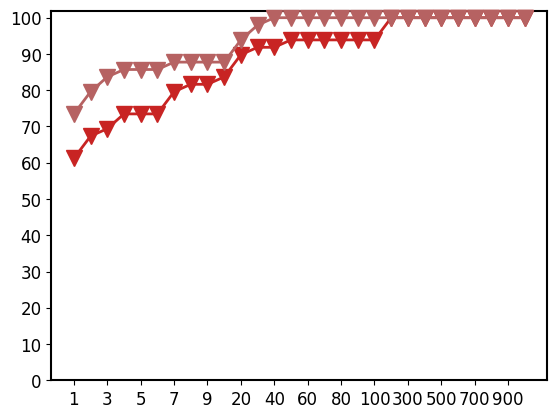

In [14]:
#performance on testing set 1
performance('test1')

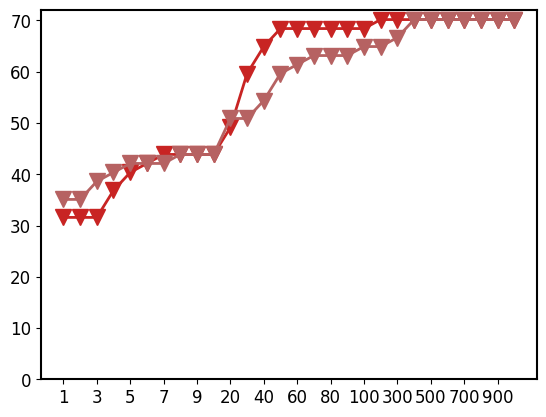

In [15]:
#performance on testing set 2
performance('test2')

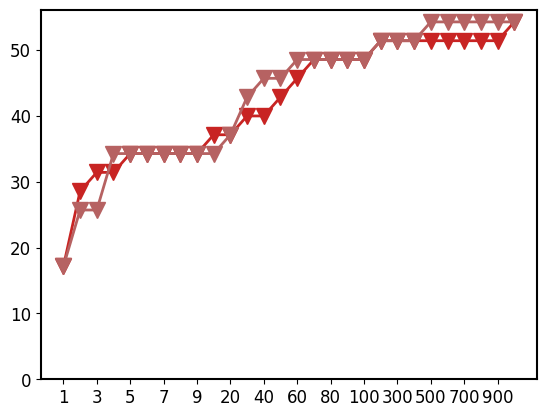

In [16]:
#performance on testing set 3
performance('test3')